# Regularización mediante el tamaño de la red neuronal: Ejemplo con el California Housing Dataset

En este cuaderno vamos a mostrar cómo, a la hora de entrenar modelos de Deep Learning (en este caso, redes neuronales MLP), una manera de "regularizar" o controlar la complejidad del modelo es ajustar el tamaño de la red (número de capas, neuronas, etc.).

El objetivo es mostrar que a veces no es necesario usar redes muy grandes y complejas para alcanzar un buen desempeño. Para ello, usaremos el dataset *California Housing* incluido en `sklearn`, que es un problema de regresión donde se busca predecir el valor medio de las casas en diferentes distritos de California a partir de variables censales.

Procederemos así:
1. Analizaremos brevemente el conjunto de datos.
2. Entrenaremos un modelo MLP "grande" y evaluaremos su desempeño.
3. Entrenaremos un modelo MLP más "pequeño" y mostraremos cómo, en ciertos casos, su desempeño no es muy distinto.
4. Presentaremos las conclusiones finales.

## 1) Carga y análisis preliminar del California Housing Dataset

El dataset de California Housing disponible en `sklearn.datasets` contiene datos de la década de los 90 sobre:
- Valor medio de la vivienda en una zona (MedInc)
- Información demográfica, geográfica y económica.

La tarea es la de regresión: predecir el valor medio de las casas en miles de dólares.

A continuación:
- Cargaremos los datos.
- Mostraremos algunas estadísticas y su dimensión.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Carga del dataset
data = fetch_california_housing()
X = data.data
y = data.target

# Convertimos a DataFrame para un análisis más cómodo
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [2]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Como podemos observar, el dataset tiene un número moderado de muestras (más de 20k) y varias características. El target (mediana del precio de la vivienda en cientos de miles de dólares) varía entre ~0.14 y ~5.0.

Ahora dividiremos el dataset en entrenamiento y test. Así entrenaremos nuestro modelo en el conjunto de entrenamiento y evaluaremos su rendimiento en el conjunto de test para evaluar la capacidad de generalización.

In [3]:
# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizamos las características (Z-score)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((16512, 8), (4128, 8))

## 2) Definición de funciones y clases para entrenar MLP con PyTorch

A continuación, usaremos PyTorch para construir nuestros modelos MLP. Definiremos:
- Una clase genérica para el modelo MLP.
- Funciones para entrenar el modelo.
- Funciones de evaluación (en la siguiente sección).

Nuestro objetivo es un problema de regresión, así que usaremos una función de pérdida como el Error Cuadrático Medio (MSELoss).

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim=1, activation=nn.ReLU()):
        super(MLP, self).__init__()
        
        layers = []
        in_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation)
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, device='cpu'):
    model = model.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * Xb.size(0)
        
        epoch_train_loss /= len(train_loader.dataset)
        
        # Validación
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb)
                loss = criterion(preds, yb)
                epoch_val_loss += loss.item() * Xb.size(0)
        epoch_val_loss /= len(val_loader.dataset)
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        # Print opcional
        if (epoch+1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
            
    return train_losses, val_losses


def predict(model, data_loader, device='cpu'):
    model = model.to(device)
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for Xb, yb in data_loader:
            Xb = Xb.to(device)
            preds = model(Xb)
            predictions.append(preds.cpu().numpy().ravel())
            targets.append(yb.numpy().ravel())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

## 3) Funciones para evaluar el desempeño de los modelos

Definiremos funciones para obtener estas métricas y también para graficar predicciones vs. valores reales.

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

def plot_predictions(y_true, y_pred, title="Pred vs True"):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(title)
    plt.grid(True)
    plt.show()

## Preparación de Dataloaders

Vamos a crear `DataLoader` de PyTorch para entrenamiento y validación. Dividiremos el conjunto de entrenamiento further en train y validation (por ejemplo, 80% train - 20% val del conjunto original de training). Esto nos permitirá ajustar hiperparámetros sin mirar el test.

In [7]:
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Creación del dataset de entrenamiento
train_dataset = TensorDataset(X_train_t, y_train_t)

# Dividimos train en train y val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

## 4) Entrenamiento de un modelo complejo

Primero vamos a plantear un modelo relativamente grande. Por ejemplo, una MLP con varias capas y bastantes neuronas: [64, 64, 64, 32, 32].

Entrenaremos este modelo y veremos su desempeño.

In [8]:
input_dim = X_train.shape[1]
print(f'Input size: {input_dim}')
hidden_layers = [64, 64, 64, 32, 32]  # Modelo "grande"
model_complex = MLP(input_dim, hidden_layers, output_dim=1, activation=nn.ReLU())
print(model_complex)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_complex.parameters(), lr=0.001)

train_losses_complex, val_losses_complex = train_model(model_complex, train_loader, val_loader, criterion, optimizer, epochs=200, device='cpu')

Input size: 8
MLP(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Epoch [20/200] - Train Loss: 0.2740, Val Loss: 0.3171
Epoch [40/200] - Train Loss: 0.2390, Val Loss: 0.2991
Epoch [60/200] - Train Loss: 0.2172, Val Loss: 0.2870
Epoch [80/200] - Train Loss: 0.1994, Val Loss: 0.2918
Epoch [100/200] - Train Loss: 0.1828, Val Loss: 0.2869
Epoch [120/200] - Train Loss: 0.1672, Val Loss: 0.3016
Epoch [140/200] - Train Loss: 0.1541, Val Loss: 0.2985
Epoch [160/200] - Train Loss: 0.1390, Val Loss: 0.3111
Epoch [180/200] - Train Loss: 0.1294, Val Loss: 0.3074
Epoch [200/200] - Train 

In [10]:
y_pred_test_complex, y_test_eval = predict(model_complex, test_loader, device='cpu')
mse_c, rmse_c, r2_c = evaluate_predictions(y_test_eval, y_pred_test_complex)
print("Modelo Complejo:")
print(f"Test MSE: {mse_c:.4f}")
print(f"Test RMSE: {rmse_c:.4f}")
print(f"Test R²: {r2_c:.4f}")

Modelo Complejo:
Test MSE: 0.3068
Test RMSE: 0.5539
Test R²: 0.7659


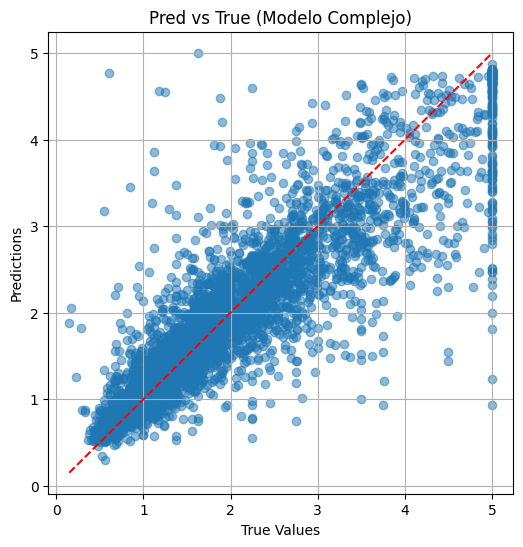

In [11]:
plot_predictions(y_test_eval, y_pred_test_complex, title="Pred vs True (Modelo Complejo)")

## 5) Entrenamiento de un modelo más sencillo

Ahora plantearemos un modelo con menos capacidad. Por ejemplo: [32, 16]. Una red más pequeña que consuma menos recursos y se entrene más rápido.

Veamos si aún así podemos obtener un desempeño competitivo.

In [12]:
model_simple = MLP(input_dim, [32, 16], output_dim=1, activation=nn.ReLU())
print(model_simple)

optimizer_simple = optim.Adam(model_simple.parameters(), lr=0.001)
train_losses_simple, val_losses_simple = train_model(model_simple, train_loader, val_loader, criterion, optimizer_simple, epochs=200, device='cpu')

MLP(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
Epoch [20/200] - Train Loss: 0.3105, Val Loss: 0.3306
Epoch [40/200] - Train Loss: 0.2897, Val Loss: 0.3133
Epoch [60/200] - Train Loss: 0.2807, Val Loss: 0.3153
Epoch [80/200] - Train Loss: 0.2740, Val Loss: 0.3071
Epoch [100/200] - Train Loss: 0.2704, Val Loss: 0.2996
Epoch [120/200] - Train Loss: 0.2639, Val Loss: 0.3069
Epoch [140/200] - Train Loss: 0.2622, Val Loss: 0.3030
Epoch [160/200] - Train Loss: 0.2590, Val Loss: 0.2939
Epoch [180/200] - Train Loss: 0.2529, Val Loss: 0.2990
Epoch [200/200] - Train Loss: 0.2501, Val Loss: 0.2941


In [13]:
y_pred_test_simple, y_test_eval = predict(model_simple, test_loader, device='cpu')
mse_s, rmse_s, r2_s = evaluate_predictions(y_test_eval, y_pred_test_simple)
print("Modelo Sencillo:")
print(f"Test MSE: {mse_s:.4f}")
print(f"Test RMSE: {rmse_s:.4f}")
print(f"Test R²: {r2_s:.4f}")

Modelo Sencillo:
Test MSE: 0.2842
Test RMSE: 0.5331
Test R²: 0.7831


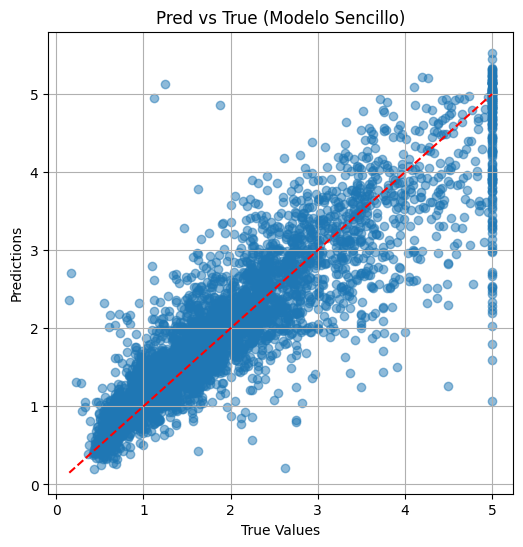

In [14]:
plot_predictions(y_test_eval, y_pred_test_simple, title="Pred vs True (Modelo Sencillo)")

## Comparación de pérdidas durante el entrenamiento

Podemos comparar cómo evolucionaron las pérdidas de entrenamiento y validación en ambos modelos.

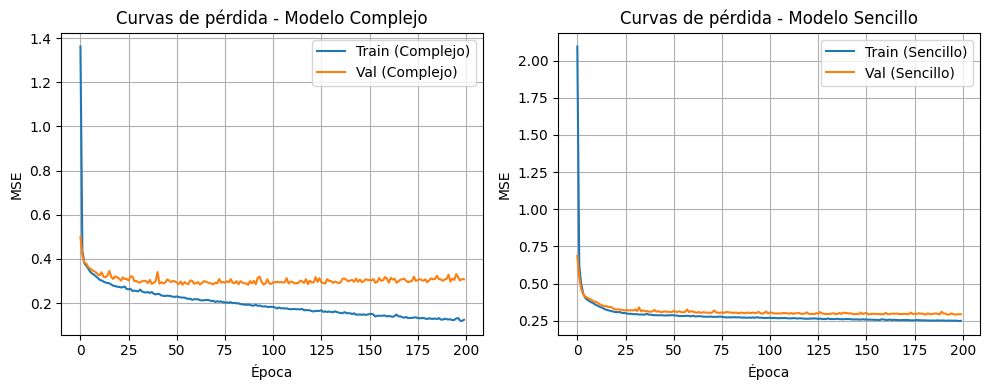

In [15]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses_complex, label='Train (Complejo)')
plt.plot(val_losses_complex, label='Val (Complejo)')
plt.title("Curvas de pérdida - Modelo Complejo")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses_simple, label='Train (Sencillo)')
plt.plot(val_losses_simple, label='Val (Sencillo)')
plt.title("Curvas de pérdida - Modelo Sencillo")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 6) Conclusiones

En este cuaderno hemos visto un ejemplo del uso del dataset de California Housing con redes neuronales MLP.

- Definimos un modelo complejo con múltiples capas y neuronas.
- Definimos un modelo más simple y ligero.
- Observamos que el modelo más simple puede alcanzar un desempeño similar al modelo complejo. Incluso si no es idéntico, puede que la ganancia al tener más complejidad no sea muy elevada en términos de métricas como el RMSE o R².

Este ejemplo ilustra cómo, muchas veces, no es necesario incrementar la complejidad del modelo para obtener un buen desempeño. Ajustar el tamaño de la red puede ser una forma de regularización, ayudando a evitar sobreajuste y reduciendo el costo computacional.

En definitiva, reducir el tamaño de la red puede resultar en modelos más simples, más rápidos de entrenar y con un desempeño competitivo, sirviendo así como una forma de regularización.